In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Discrete Spectrum

In [2]:
# import DiscSpec
from discSpec import *

In [3]:
# This runs the code in regular form using inp.dat
par = common.readInput('inp.dat')
_, g, tau, _ = getDiscSpec(par)
plt.clf()

Input parameters look OK ...

(*) Start
(*) Loading Data Files: ... tests/test3.dat...

(*) Number of optimum nodes = 5

(*) Condition number of matrix equation: 6.053578e+03


		Modes
		-----


i 	    g(i) 	    tau(i)

---------------------------------------

  1 	 1.20967e+00 	 4.73258e-02
  2 	 1.24444e+00 	 1.09084e+00
  3 	 6.53837e-01 	 9.07297e+00
  4 	 9.16067e-01 	 5.02082e+01
  5 	 1.79887e-02 	 4.81048e+02




In [4]:
def guiFurnishGlobals(par):

    # toggle flags to prevent printing    
    par['verbose'] = False
    par['plotting'] = False
    
    # Read experimental data
    t, Gexp = common.GetExpData(par['GexpFile'])

    # Read continuous spectrum
    s, H    = np.loadtxt('output/H.dat', unpack=True)    

    # Read continuous fit
    _, Gfitc = np.loadtxt('output/Gfit.dat', unpack=True)    
    
    wt  = GetWeights(H, t, s)
    wt  = wt/np.trapz(wt, np.log(s))
    
    return s, H, t, Gexp, Gfitc, wt

In [5]:
s, H, t, Gexp, Gfitc, wt0 = guiFurnishGlobals(par)

In [10]:
def guiUpdatePlot(BaseDistWt=0.5, condWt=0.5):
    
    wt  = (1. - BaseDistWt) * wt0 + BaseDistWt*np.mean(wt0)*np.ones(len(wt0))

    # calculation
    n     = len(t)
    Nmax  = min(np.floor(3.0 * np.log10(max(t)/min(t))),n/4); # maximum N
    Nmin  = max(np.floor(0.5 * np.log10(max(t)/min(t))),3);   # minimum N    
    Nv    = np.arange(Nmin, Nmax + 1).astype(int)
    
    npts  = len(Nv)
    ev    = np.zeros(npts)
    condN = np.zeros(npts)

    for i in np.arange(npts):
        N      = Nv[i]
        z, hz  = GridDensity(np.log(s), wt, N)     # Select "tau" Points
        g, tau, ev[i], condN[i] = MaxwellModes(z, t, Gexp)
    
    emin     = min(ev);
    condNmin = min(condN);
    cost     = (1 - condWt) * (ev - emin)**2 + condWt  * (np.log(condN/condNmin))**2
    
    # optimum
    Nopt               = Nv[np.argmin(cost)]    
    z, hz              = GridDensity(np.log(s),wt,Nopt)           # Select "tau" Points
    g, tau, error, cKp = MaxwellModes(z, t, Gexp)   # Get g_i
    
    # plotting
    
    fig, ax = plt.subplots(figsize=(14,4), nrows=1, ncols=3)

    # continuous and discrete spectra
    ax[0].loglog(tau,g,'o-', label='disc')
    ax[0].loglog(s, np.exp(H), label='cont')
    ax[0].set_xlabel(r'$\tau$')
    ax[0].set_ylabel(r'$g$')
    ax[0].legend(loc='lower right')
    
    # predicted and actual values
    S, T    = np.meshgrid(tau, t)
    K       = np.exp(-T/S)
    GtM     = np.dot(K, g)    
    ax[1].loglog(t,Gexp,'o')
    ax[1].loglog(t,GtM, label='disc')
    ax[1].loglog(t,Gfitc, label='cont')
    ax[1].set_xlabel(r'$t$')
    ax[1].set_ylabel(r'$G(t)$')
    ax[1].legend(loc='lower left')

    ax[2].plot(Nv, ev, label='error')
    ax[2].plot(Nv, condN, label='cond#')
    ax[2].plot(Nv, cost, '--', label='costFn')
    ax[2].set_yscale('log')
    ax[2].set_xlabel('# modes')
    ax[2].scatter(Nopt, np.min(cost))
    ax[2].legend()

    # figure settings
    fig.tight_layout()
    
    plt.show()

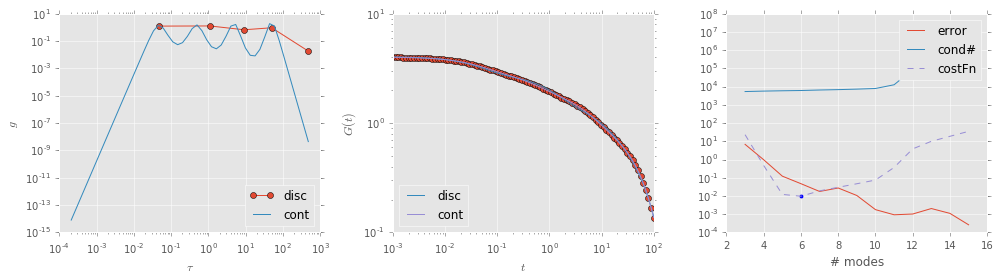

In [11]:
guiUpdatePlot(BaseDistWt=0.5, condWt=0.5)

### Interactivity

In [12]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [13]:
SBaseDistWt = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05, continuous_update=False)
ScondWt = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05, continuous_update=False)
interact(guiUpdatePlot, BaseDistWt=SBaseDistWt, condWt=ScondWt)

<function __main__.guiUpdatePlot>